# Fit multiple potential SNIa with `sncosmo`

Import packages.

In [1]:
import sncosmo
import iminuit
import numpy as np

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define the  model for `sncosmo`.

In [2]:
model = sncosmo.Model(source='salt2')

Read in the nightly epoch lightcurves for all "good" candidates from 2021.

In [3]:
path = '../extragalactic_fields/candidate_nightly_epochs_files/'
fnm = path + 'candidate_lightcurves.dat'
candLC_field   = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid  = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd     = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter  = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj    = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag     = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage    = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb     = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_maglim  = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

Read in the list of candidate IDs for potential SNIa that Melissa made with the MLG_snia_menagerie.ipynb notebook.

In [4]:
path = '../extragalactic_fields/science_with_candidates/MLG_snia_menagerie_files/'
fnm = path + 'potential_snia_list.dat'
potSNIa_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
del fnm

In [5]:
# print(potSNIa_candid)

Define arrays to hold their fit results.

In [6]:
fit_z   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ze  = np.zeros(len(potSNIa_candid), dtype='float') 
fit_t0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_t0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1e = np.zeros(len(potSNIa_candid), dtype='float')
fit_c   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ce  = np.zeros(len(potSNIa_candid), dtype='float')

Run `sncosmo` for just 5 of the potential SNIa for now.

In [7]:
for c in range(5):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')
    
    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.3, 0.7)})
    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']
    

See how the results arrays are populated.

In [8]:
print(fit_z)

[0.41130085 0.50496126 0.32988932 0.55752008 0.50659747 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


Yup OK, looks like the basic process above is going to work OK.

**TO DO!!**

Add a step to the fitting process abobe that involves estimating the likely redshift range for the SNIa from its peak brightness, and then using that smaller range for the boundaries in the `sncosmo.fit_lc()` command.

Then do the fit for ALL the potential SNIa, not just 5.

Then, explore their results. You can make plots of the distributions of values, compare relations between values, look at which potential SNIa have big errors. 

___

## Estimating likely redshift range for fitting all potential SNIa

In [9]:
# Check number of potential candidates
len(potSNIa_candid)

51

#### Run `sncosmo` (with additional step for redshift range)

In [10]:
for c in range(len(potSNIa_candid)):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')

##### EXTRA STEP #####

    # find redshift range for fit
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift
    
    # use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to an error @ index 43, "result was NaN". Maybe that was too broad?)
    z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range})

##### EXTRA STEP #####

    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']

Check that the result arrays are fully populated

In [11]:
fit_z

array([0.30455414, 0.23534686, 0.13828473, 0.23711929, 0.24080981,
       0.26391213, 0.24372989, 0.09829047, 0.00817146, 0.23517217,
       0.21308467, 0.00408214, 0.20804926, 0.25144624, 0.30414446,
       0.19730807, 0.1330263 , 0.35715839, 0.27784635, 0.19667554,
       0.27298699, 0.08276718, 0.20185372, 0.13703677, 0.21852496,
       0.32272964, 0.05247889, 0.16165937, 0.12395756, 0.27885112,
       0.16028576, 0.11928276, 0.06894901, 0.23118046, 0.3090151 ,
       0.18675243, 0.31191442, 0.24865049, 0.31080331, 0.26790507,
       0.34836634, 0.14627623, 0.16404701, 0.1623938 , 0.3434681 ,
       0.27766421, 0.16518354, 0.32588273, 0.36071653, 0.12701025,
       0.15894617])

## Analyzing the results

In [12]:
import matplotlib.pyplot as plt

### Looking at the fit parameter distributions

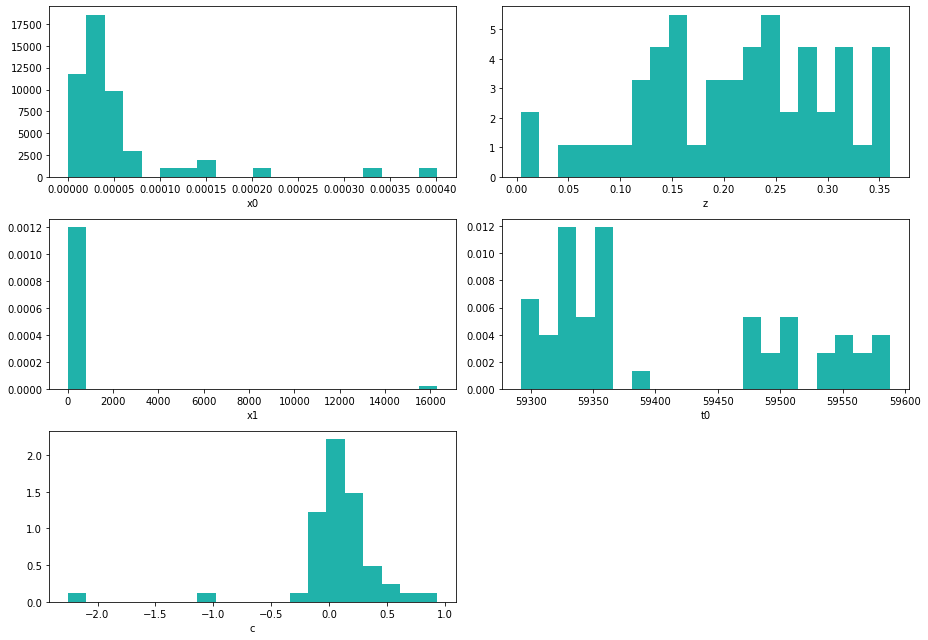

In [13]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=True, histtype='stepfilled', color='lightseagreen')
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_z, bins=20, density=True, histtype='stepfilled', color='lightseagreen')
ax[0,1].set_xlabel('z')

ax[1,0].hist(fit_x1, bins=20, density=True, histtype='stepfilled', color='lightseagreen')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_t0, bins=20, density=True, histtype='stepfilled', color='lightseagreen')
ax[1,1].set_xlabel('t0')

ax[2,0].hist(fit_c, bins=20, density=True, histtype='stepfilled', color='lightseagreen')
ax[2,0].set_xlabel('c')

fig.tight_layout()
fig.show()

Each fit parameter (x0, x1, & c) seems to have a general range for values. However, the VERY outlying value of x1 potentially is making the rest of the distribution seem "normal". Perhaps these are the "normal" value ranges that indicate a good fit to SN Ia? (**I'll have to come back to this after reading papers) All these SN Ia have redshift z<~0.4

Let's look closer at the x1 distribution, omitting the x1= ~16000 point.

In [14]:
# Find which index in our fit_x1 array that has the extreme value
np.where(fit_x1 > 14000)

(array([43]),)

In [15]:
# Double-check the value
fit_x1[43]

16303.842852915046

In [16]:
# Create a new fit_x1 array that doesn't include the extreme value we just found
fit_x1_new = np.delete(fit_x1, 43, 0)
len(fit_x1_new)

50

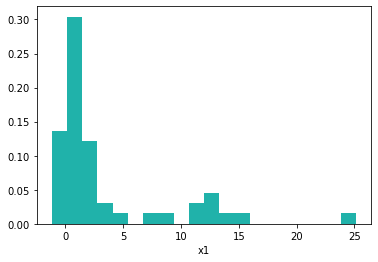

In [17]:
# Replot x1 data
plt.hist(fit_x1_new, bins=20, density=True, histtype='stepfilled', color='lightseagreen')
plt.xlabel('x1');

This looks much better/more meaningful. Even x1~25 now looks to be an outlier. `x1 values seem to peak around 1.`

Outliers in each of these plots above could be indications of bad fits to type 1a supernovae? Let's look at the fitted plots for these candidates with such odd parameter values.

### Looking at the fits of candidates with outlying parameter values

In [18]:
# Find which index in our fit_c array that has outlying value
np.where(fit_c < -2.0)

(array([2]),)

In [19]:
# Double-checking the value
fit_c[2]

-2.25628643285136

In [20]:
# Also want to check the other parameters
print(fit_x0[2])
print(fit_x1[2])

0.000401171169106386
1.0904914089006836




Interesting. The x0 value is another obvious outlier from its distribution, but its x1 actually appears to have a normal value! Maybe x1 values won't always indicate a good/bad fit to a SN Ia LC??

In [21]:
# Which candidate does this correspond to
potSNIa_candid[2]

'DC21foy'

In [22]:
my_potential_snia = 'DC21foy'
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

135


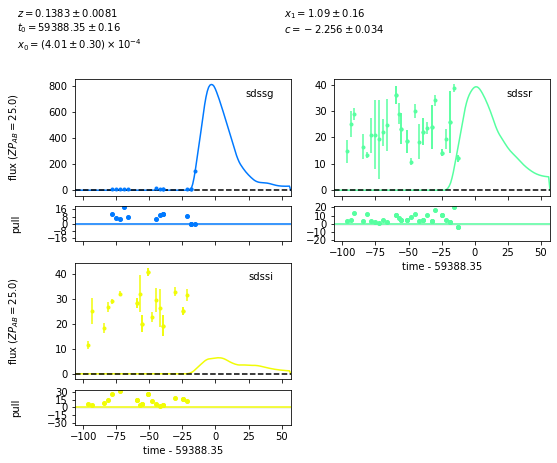

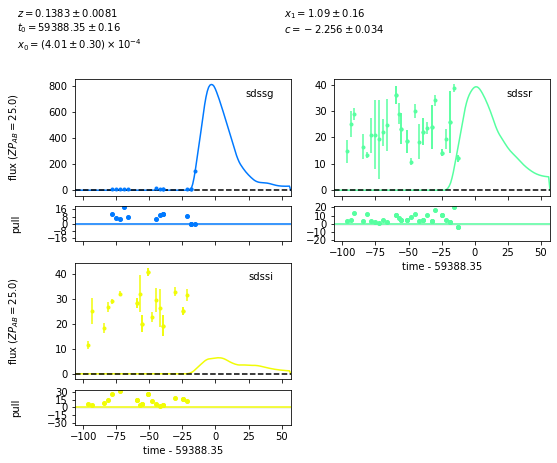

In [23]:
# Redo the fitting process and plot the fit as we've done

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data_foy = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data_foy['flux'], dtype='float')
zparr = np.asarray(data_foy['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result_foy, fitted_model_foy = sncosmo.fit_lc(data_foy, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data_foy, model=fitted_model_foy, errors=result_foy.errors)

This clearly isn't fitting the data well, which checks with what I expected since it had an outlying c & x0 values compared to their distributions. `sncosmo` fits SNIa, so this would tell us that either we don't have good data, or this candidate is not actually a type 1a supernova.

Let's check another candidate with weird parameter values.

In [24]:
np.where(fit_x0 > 0.0003)

(array([ 2, 32]),)

In [25]:
# Index 2 already corresponds with the candidate we just looked at
fit_x0[32]

0.0003409605373582961

In [26]:
# Check other parameters
print(fit_x1[32])
print(fit_c[32])

0.0
0.0


In [27]:
# Which candidate does this correspond to
potSNIa_candid[32]

'DC21mjrj'

This is also interesting. Fit values for x1 and c are both 0, with an outyling x0 value. Let's look at the fitted LC.

In [28]:
my_potential_snia = 'DC21mjrj'
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

117


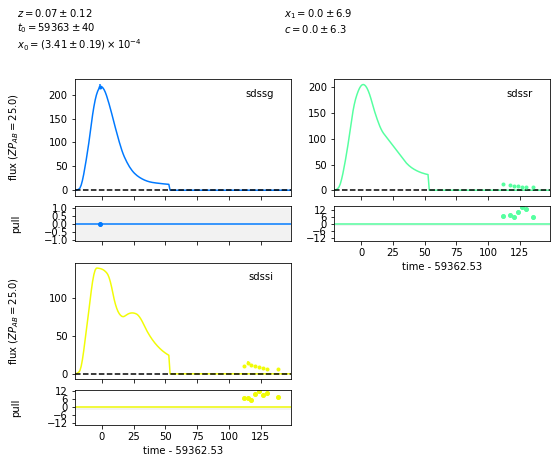

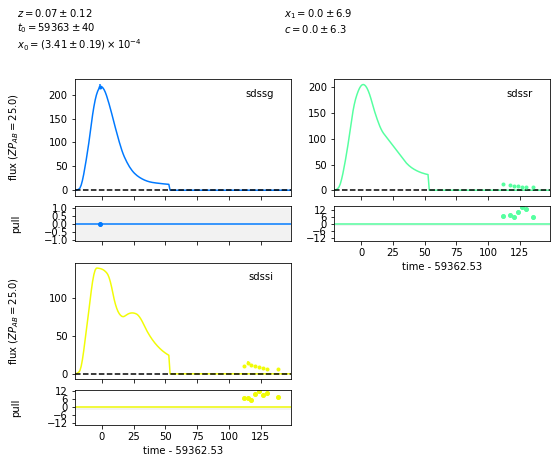

In [29]:
# Do the fitting process and plot the fit as we've done

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data_mjrj = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data_mjrj['flux'], dtype='float')
zparr = np.asarray(data_mjrj['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result_mjrj, fitted_model_mjrj = sncosmo.fit_lc(data_mjrj, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data_mjrj, model=fitted_model_mjrj, errors=result_mjrj.errors)

This also doesn't seem to fit the data well. Maybe we don't have a enough data? The g-band looks to only have one point to make a fit from. 

### Looking at the fit parameter error distributions

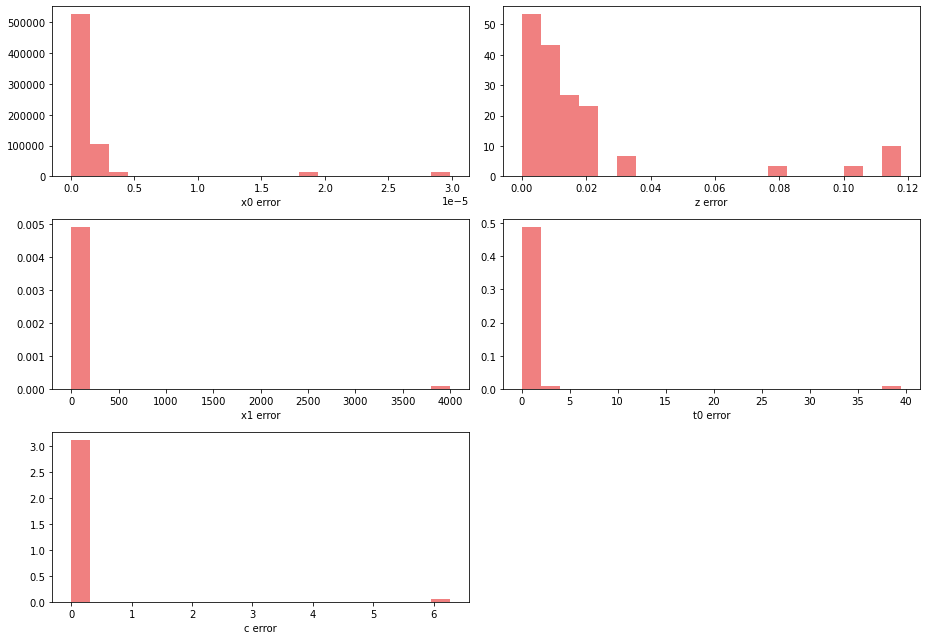

In [30]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0e, bins=20, density=True, histtype='stepfilled', color='lightcoral')
ax[0,0].set_xlabel('x0 error')

ax[0,1].hist(fit_ze, bins=20, density=True, histtype='stepfilled', color='lightcoral')
ax[0,1].set_xlabel('z error')

ax[1,0].hist(fit_x1e, bins=20, density=True, histtype='stepfilled', color='lightcoral')
ax[1,0].set_xlabel('x1 error')

ax[1,1].hist(fit_t0e, bins=20, density=True, histtype='stepfilled', color='lightcoral')
ax[1,1].set_xlabel('t0 error')

ax[2,0].hist(fit_ce, bins=20, density=True, histtype='stepfilled', color='lightcoral')
ax[2,0].set_xlabel('c error')

fig.tight_layout()
fig.show()

Of course, we usually want to have the errors of our values pretty small, and the majority of our errors lie close to 0. That can indicate our values are pretty accurate. However, there are exceptions?

### Looking at the fits of candidates with large errors in parameters

Similarly as I did with candidates that have outlying parameter values, I will look at the fits of candidates that have large errors.

In [31]:
np.where(fit_x1e > 3500)

(array([43]),)

In [32]:
fit_x1e[43]

4003.817746415814

In [33]:
# Check other parameter errors
print(fit_x0e[43])
print(fit_ce[43])

3.1158114890117546e-08
0.028957674622156416


It's x0 error is also very large. I also realize x1 and c distributions might look a bit different if we omitted the outlying values. But let's look at this candidate's fit first.

In [34]:
# Which candidate does this correspond to
potSNIa_candid[43]

'DC21dglus'

In [35]:
my_potential_snia = 'DC21dglus'
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

117


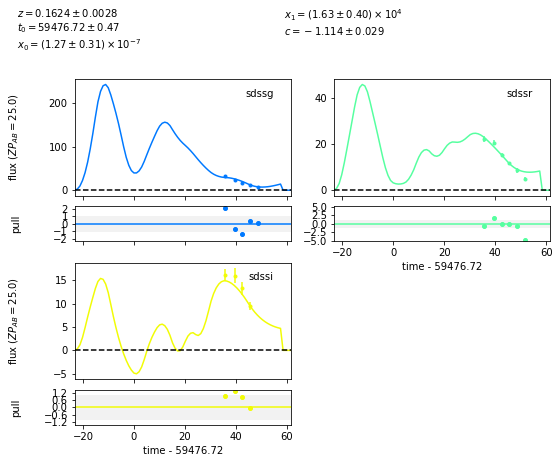

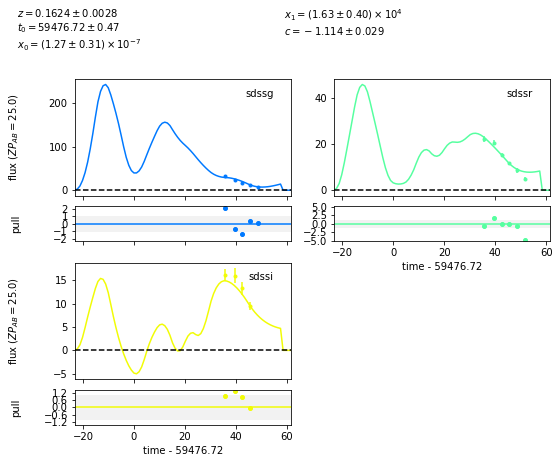

In [36]:
# Do the fitting process and plot the fit as we've done

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data_dglus = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data_dglus['flux'], dtype='float')
zparr = np.asarray(data_dglus['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result_dglus, fitted_model_dglus = sncosmo.fit_lc(data_dglus, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data_dglus, model=fitted_model_dglus, errors=result_dglus.errors)

Yep, this is definetly not fit well. This fit also looks the worst compared to the fits oof candidates with outlying values from earlier. There are multiple maxima, nothing like a typical SNIa lightcurve.

Now lets revisit the error distributions of x1 and c errors, omitting some of the extreme values.

In [37]:
np.where(fit_x1e > 3500)

(array([43]),)

In [38]:
fit_x1e_new = np.delete(fit_x1e, 43, 0)

In [39]:
np.where(fit_ce > 6)

(array([32]),)

In [40]:
fit_ce_new = np.delete(fit_ce, 32, 0)

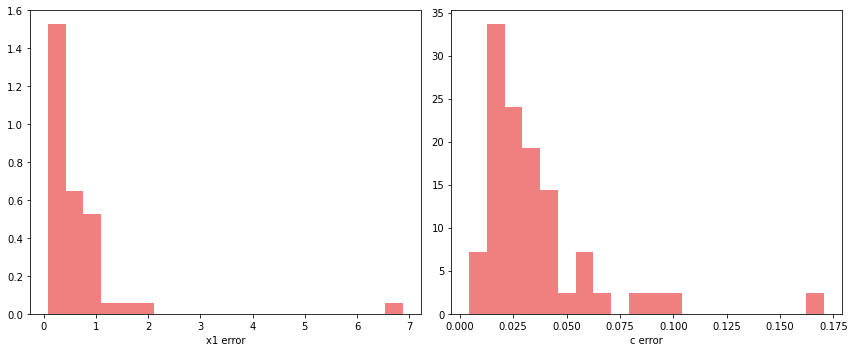

In [41]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

ax[0].hist(fit_x1e_new, bins=20, density=True, histtype='stepfilled', color='lightcoral')
ax[0].set_xlabel('x1 error')

ax[1].hist(fit_ce_new, bins=20, density=True, histtype='stepfilled', color='lightcoral')
ax[1].set_xlabel('c error')

fig.tight_layout()
fig.show()

Looks like we found some new "large" errors. So the c error for DC21dglus doesn't seem to be abnormal.

In [42]:
np.where(fit_ce > 6)

(array([32]),)

In [43]:
# Check other parameter errors
print(fit_x0e[32])
print(fit_x1e[32])

1.8503892472580294e-05
6.882389844154195


Both these values are decently large compared to the peak of their distributions.

In [44]:
# Which candidate does this correspond to
potSNIa_candid[32]

'DC21mjrj'

Oh this is the same candidate we looked at for outlying parameter values! So DC21mjrj had both odd parameter values AND errors.

### Comparing relations between values

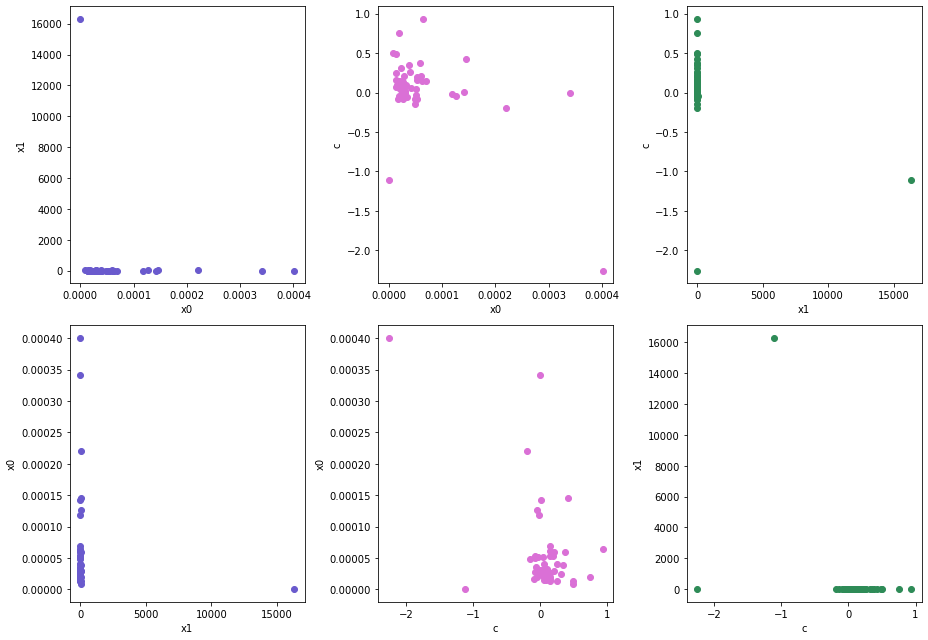

In [45]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(fit_x0, fit_x1, color='slateblue')
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('x1')

ax[0,1].scatter(fit_x0, fit_c, color='orchid')
ax[0,1].set_xlabel('x0')
ax[0,1].set_ylabel('c')

ax[0,2].scatter(fit_x1, fit_c, color='seagreen')
ax[0,2].set_xlabel('x1')
ax[0,2].set_ylabel('c')

ax[1,0].scatter(fit_x1, fit_x0, color='slateblue')
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x0')

ax[1,1].scatter(fit_c, fit_x0, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel('x0')

ax[1,2].scatter(fit_c, fit_x1, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel('x1')


fig.tight_layout()
fig.show()

Just some messing around with this section so far. I'm not sure if this tells us much? Maybe I'm doing this wrong.